In [1]:
import argparse as argp
import glob
import os
import shutil
import sys
import time
from functools import partial

import jax
import minkasi.minkasi_all as minkasi
import numpy as np
import yaml
from astropy import units as u
from astropy.coordinates import Angle

import minkasi_jax.presets_by_source as pbs
from minkasi_jax import helper
from minkasi_jax.utils import *

%load_ext autoreload
%autoreload 2

mpi4py imported
nproc:,  1


I0000 00:00:1702528536.406801  278047 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
with open("/home/r/rbond/jorlo/dev/minkasi_jax/configs/MOOJ2354/MOOJ2354_a10.yaml", "r") as file:
    cfg = yaml.safe_load(file)
if "models" not in cfg:
    cfg["models"] = {}
fit = True


In [3]:
dev_id = cfg.get("jax_device", 0)
device = jax.devices()[dev_id]

# Setup coordindate stuff
z = eval(str(cfg["coords"]["z"]))
da = get_da(z)
r_map = eval(str(cfg["coords"]["r_map"]))
dr = eval(str(cfg["coords"]["dr"]))
dr = (lambda x: x if type(x) is tuple else (x,))(dr)
coord_conv = eval(str(cfg["coords"]["conv_factor"]))
x0 = eval(str(cfg["coords"]["x0"]))
y0 = eval(str(cfg["coords"]["y0"]))

xyz = make_grid(r_map, *dr)
xyz = jax.device_put(xyz, device)
xyz[0].block_until_ready()
xyz[1].block_until_ready()
xyz[2].block_until_ready()
dr = eval(str(cfg["coords"]["dr"]))
# Load TODs
tod_names = glob.glob(os.path.join(cfg["paths"]["tods"], cfg["paths"]["glob"]))
bad_tod, addtag = pbs.get_bad_tods(
    cfg["cluster"]["name"], ndo=cfg["paths"]["ndo"], odo=cfg["paths"]["odo"]
)
if "cut" in cfg["paths"]:
    bad_tod += cfg["paths"]["cut"]
#tod_names = minkasi.cut_blacklist(tod_names, bad_tod)
tod_names.sort()
ntods = cfg["minkasi"].get("ntods", None)
tod_names = tod_names[:ntods]
tod_names = tod_names[minkasi.myrank :: minkasi.nproc]


In [4]:
todvec = minkasi.TodVec()
ntods = 2
for i, fname in enumerate(tod_names):
    if i > ntods: break
    dat = minkasi.read_tod_from_fits(fname)
    minkasi.truncate_tod(dat)

    # figure out a guess at common mode and (assumed) linear detector drifts/offset
    # drifts/offsets are removed, which is important for mode finding.  CM is *not* removed.
    dd, pred2, cm = minkasi.fit_cm_plus_poly(dat["dat_calib"], cm_ord=3, full_out=True)
    dat["dat_calib"] = dd
    dat["pred2"] = pred2
    dat["cm"] = cm

    # Make pixelized RA/Dec TODs
    idx, idy = tod_to_index(dat["dx"], dat["dy"], x0, y0, r_map, dr, coord_conv)
    idu, id_inv = np.unique(
        np.vstack((idx.ravel(), idy.ravel())), axis=1, return_inverse=True
    )
    dat["idx"] = jax.device_put(idu[0], device)
    dat["idy"] = jax.device_put(idu[1], device)
    dat["id_inv"] = id_inv
    dat["model_idx"] = idx
    dat["model_idy"] = idy

    tod = minkasi.Tod(dat)
    todvec.add_tod(tod)


WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 932
ndata and ndet are  178 24709 178  on  /scratch/r/rbond/jorlo/M2-TODs/MOOJ2354/Signal_TOD-AGBT23B_120_02-s10.fits with lims  358.5725551228934 358.79084796876697 34.999484156316534 35.185227735700444
truncating from  24709  to  24697
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 932
ndata and ndet are  170 24708 170  on  /scratch/r/rbond/jorlo/M2-TODs/MOOJ2354/Signal_TOD-AGBT23B_120_02-s14.fits with lims  358.59484886034426 358.8188790651207 35.02578721481025 35.20651743534338
truncating from  24708  to  24697
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 932
ndata and ndet are  176 24708 176  on  /scratch/r/rbond/jorlo/M2-TODs/MO

In [5]:
from pixell import utils
dat["dx"]/utils.arcsec-x0/utils.arcsec

array([[-163.48661388, -163.38825916, -163.19154971, ...,  134.13478109,
         134.33149054,  134.42984526],
       [-169.6829615 , -169.48625205, -169.19118788, ...,  113.87370793,
         114.07041738,  114.16877211],
       [-187.78023072, -187.58352127, -187.48516655, ...,   94.39947257,
          94.69453674,   94.79289147],
       ...,
       [-134.86538918, -134.66867974, -134.47197029, ...,  147.60937828,
         147.80608773,  147.90444245],
       [-115.2927991 , -115.09608965, -114.99773493, ...,  172.00134985,
         172.19805929,  172.29641402],
       [-152.96265841, -152.76594896, -152.66759424, ...,  128.23349764,
         128.52856182,  128.52856182]])

In [6]:

# make a template map with desired pixel size an limits that cover the data
# todvec.lims() is MPI-aware and will return global limits, not just
# the ones from private TODs
lims = todvec.lims()
pixsize = 2.0 / 3600 * np.pi / 180
skymap = minkasi.SkyMap(lims, pixsize)

Te = eval(str(cfg["cluster"]["Te"]))
freq = eval(str(cfg["cluster"]["freq"]))
beam = beam_double_gauss(
    dr,
    eval(str(cfg["beam"]["fwhm1"])),
    eval(str(cfg["beam"]["amp1"])),
    eval(str(cfg["beam"]["fwhm2"])),
    eval(str(cfg["beam"]["amp2"])),
)
beam = jax.device_put(beam, device)
# Setup fit parameters
funs = []
npars = []
labels = []
params = []
to_fit = []
priors = []
prior_vals = []
re_eval = []
par_idx = {}
subtract = []
for mname, model in cfg["models"].items():
    npars.append(len(model["parameters"]))
    _to_fit = []
    _re_eval = []
    _par_idx = {}
    for name, par in model["parameters"].items():
        labels.append(name)
        par_idx[mname + "-" + name] = len(params)
        _par_idx[mname + "-" + name] = len(_to_fit)
        params.append(eval(str(par["value"])))
        _to_fit.append(eval(str(par["to_fit"])))
        if "priors" in par:
            priors.append(par["priors"]["type"])
            prior_vals.append(eval(str(par["priors"]["value"])))
        else:
            priors.append(None)
            prior_vals.append(None)
        if "re_eval" in par and par["re_eval"]:
            _re_eval.append(str(par["value"]))
        else:
            _re_eval.append(False)
    to_fit = to_fit + _to_fit
    re_eval = re_eval + _re_eval
    # Special case where function is helper
    if model["func"][:15] == "partial(helper,":
        func_str = model["func"][:-1]
        if "xyz" not in func_str:
            func_str += ", xyz=xyz"
        if "beam" not in func_str:
            func_str += ", beam=beam"
        if "argnums" not in func_str:
            func_str += ", argnums=np.where(_to_fit)[0]"
        if "re_eval" not in func_str:
            func_str += ", re_eval=_re_eval"
        if "par_idx" not in func_str:
            func_str += ", par_idx=_par_idx"
        func_str += ")"
        model["func"] = func_str

    funs.append(eval(str(model["func"])))
    if "sub" in model:
        subtract.append(model["sub"])
    else:
        subtract.append(True)


In [7]:
npars = np.array(npars)
labels = np.array(labels)
params = np.array(params)
to_fit = np.array(to_fit, dtype=bool)
priors = np.array(priors)

noise_class = eval(str(cfg["minkasi"]["noise"]["class"]))
noise_args = eval(str(cfg["minkasi"]["noise"]["args"]))
noise_kwargs = eval(str(cfg["minkasi"]["noise"]["kwargs"]))

sub_poly = False
if "bowling" in cfg:
    sub_poly = cfg["bowling"]["sub_poly"]
if sub_poly:
    method = cfg["bowling"]["method"]
    degree = cfg["bowling"]["degree"]
sim = False
if "sim" in cfg:
    sim = cfg["sim"]


In [8]:
if "bowling" in cfg:
    sub_poly = cfg["bowling"]["sub_poly"]
if sub_poly:
    method = cfg["bowling"]["method"]
    degree = cfg["bowling"]["degree"]
sim = False
if "sim" in cfg:
    sim = cfg["sim"]
for i, tod in enumerate(todvec.tods):
    ipix = skymap.get_pix(tod)
    tod.info["ipix"] = ipix

    if sub_poly:
        tod.set_apix()
        for j in range(tod.info["dat_calib"].shape[0]):
            x, y = tod.info["apix"][j], tod.info["dat_calib"][j] - tod.info[method][j]
            res = np.polynomial.polynomial.polyfit(x, y, cfg["bowling"]["degree"])
            tod.info["dat_calib"][j] -= np.polynomial.polynomial.polyval(x, res)

    if sim:
        tod.info["dat_calib"] *= (-1) ** ((minkasi.myrank + minkasi.nproc * i) % 2)
        start = 0
        model = 0
        for n, fun in zip(npars, funs):
            model += fun(params[start : (start + n)], tod)[1]
            start += n
        tod.info["dat_calib"] += np.array(model)

    tod.set_noise(noise_class, *noise_args, **noise_kwargs)


got svd
got svd
got svd


In [9]:
# Figure out output
models = [
    mn + ("_ns" * (not ns)) for mn, ns in zip(list(cfg["models"].keys()), subtract)
]
outdir = os.path.join(
    cfg["paths"]["outroot"],
    cfg["cluster"]["name"],
    "-".join(mn for mn in models),
)
if "subdir" in cfg["paths"]:
    outdir = os.path.join(outdir, cfg["paths"]["subdir"])
if fit:
    outdir = os.path.join(outdir, "-".join(l for l in labels[to_fit]))
else:
    outdir = os.path.join(outdir, "not_fit")
if sub_poly:
    outdir += "-" + method + "_" + str(degree)
if sim:
    outdir += "-sim"
if minkasi.myrank == 0:
    os.makedirs(outdir, exist_ok=True)



In [10]:
fit = False
if fit:
    t1 = time.time()
    pars_fit, chisq, curve, errs = minkasi.fit_timestreams_with_derivs_manyfun(
        funs,
        params,
        npars,
        todvec,
        to_fit,
        maxiter=cfg["minkasi"]["maxiter"],
        priors=priors,
        prior_vals=prior_vals,
    )
    minkasi.comm.barrier()
    t2 = time.time()
    print_once("Took", t2 - t1, "seconds to fit")

    params = pars_fit
    for i, re in enumerate(re_eval):
        if not re:
            continue
        pars_fit[i] = eval(re)

    print_once("Fit parameters:")
    for l, pf, err in zip(labels, pars_fit, errs):
        print_once("\t", l, "=", pf, "+/-", err)
    print_once("chisq =", chisq)

    if minkasi.myrank == 0:
        res_path = os.path.join(outdir, "results")
        print_once("Saving results to", res_path + ".npz")
        np.savez_compressed(
            res_path, pars_fit=pars_fit, chisq=chisq, errs=errs, curve=curve
        )


In [11]:
idxs = np.array([])
idys = np.array([])

dxs = np.array([])
dys = np.array([])

lens = np.array([])

for tod in todvec.tods:
    idxs = np.append(idxs, tod.info["idx"])
    idys = np.append(idys, tod.info["idy"])
    lens = np.append(lens, len(tod.info["dx"].ravel()))
    dxs = np.append(dxs, tod.info["model_idx"])
    dys = np.append(dys, tod.info["model_idy"])

lens = np.array(lens, dtype=int)

In [12]:
idx_min, idx_max = np.min(idxs), np.max(idxs)
idy_min, idy_max = np.min(idys), np.max(idys)
x = np.arange(idx_min, idx_max, dtype = int)
y = np.arange(idy_min, idy_max, dtype = int)

X, Y = np.meshgrid(x, y)


0.4969999272618113
[[[-180.        ]
  [-179.49930459]
  [-178.99860918]
  ...
  [ 178.99860918]
  [ 179.49930459]
  [ 180.        ]]

 [[-180.        ]
  [-179.49930459]
  [-178.99860918]
  ...
  [ 178.99860918]
  [ 179.49930459]
  [ 180.        ]]

 [[-180.        ]
  [-179.49930459]
  [-178.99860918]
  ...
  [ 178.99860918]
  [ 179.49930459]
  [ 180.        ]]

 ...

 [[-180.        ]
  [-179.49930459]
  [-178.99860918]
  ...
  [ 178.99860918]
  [ 179.49930459]
  [ 180.        ]]

 [[-180.        ]
  [-179.49930459]
  [-178.99860918]
  ...
  [ 178.99860918]
  [ 179.49930459]
  [ 180.        ]]

 [[-180.        ]
  [-179.49930459]
  [-178.99860918]
  ...
  [ 178.99860918]
  [ 179.49930459]
  [ 180.        ]]]


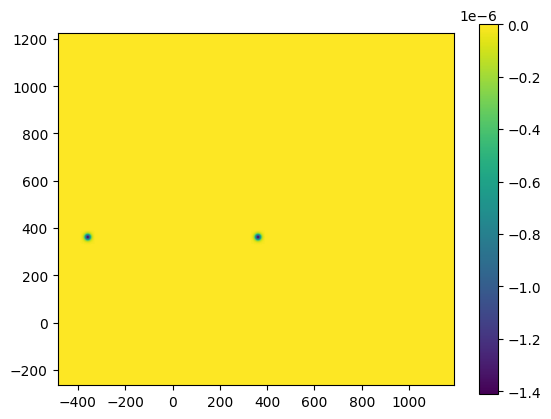

In [13]:
from minkasi_jax.core import model
import matplotlib.pyplot as plt
vis_model = model(xyz, 0, 0, 1, 0, 0, 0, 0, 0, float(y2K_RJ(freq, Te)*dr*XMpc/me), beam, X, Y, params)

plt.imshow(vis_model, extent = [np.min(X), np.max(X), np.min(Y), np.max(Y)], origin = 'lower')
plt.colorbar()

In [14]:
params

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.4030e+00,
       1.1770e+00, 1.0000e+14, 3.0810e-01, 1.0510e+00, 5.4905e+00,
       9.7000e-01])

In [15]:
labels

array(['dx_1', 'dy_1', 'dz_1', 'theta', 'P0', 'c500', 'm500', 'gamma',
       'alpha', 'beta', 'z'], dtype='<U5')

In [16]:
def gnfw(dx, dy, dz, r_1, r_2, r_3, theta, P0, c500, m500, gamma, alpha, beta, z, xyz, fix_r500=False):
    nz = get_nz(z)
    hz = get_hz(z)
    if fix_r500:
        da = get_da(z) #Maybe pass this since it's computed anyway?

    x, y, z = transform_grid(dx, dy, dz, r_1, r_2, r_3, theta, xyz)

    r500 = (m500 / (4.00 * jnp.pi / 3.00) / 5.00e02 / nz) ** (1.00 / 3.00)

    if fix_r500:
        r_1, r_2, r_3 = r500 /da, r500 / da, r500 / da
        print(r500, r_1)
    r = c500 * jnp.sqrt(x**2 + y**2 + z**2) / r500
    denominator = (r**gamma) * (1 + r**alpha) ** ((beta - gamma) / alpha)

    P500 = (
        1.65e-03
        * (m500 / (3.00e14 / h70)) ** (2.00 / 3.00 + ap)
        * hz ** (8.00 / 3.00)
        * h70**2
    )

    return P500 * P0 / denominator


In [17]:
gnfw(*params, xyz, True)

TypeError: gnfw() missing 2 required positional arguments: 'z' and 'xyz'

In [ ]:
xyz

In [ ]:
nz